In [1]:
! pip install datasets
! pip install transformers
! pip install evaluate
! pip install hyperopt
import datasets
import random
import os
from urllib import request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

# Handle GPU Settings
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Analysis of Dataset

In [3]:
# CONSTANTS

PRETRAINED_MODEL = "distilbert-base-uncased"
DATASET_PATH = "../data/dontpatronizeme_pcl_training.tsv"

df = pd.read_csv(DATASET_PATH, sep='\t')
df.head()

,par_id,art_id,keyword,country_code,text,class_labels,annotator_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,"[0, 0, 0, 0, 0, 0, 0]"
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,"[0, 0, 0, 0, 0, 0, 0]"
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0,"[0, 0, 0, 0, 0, 0, 0]"
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,"[0, 0, 0, 0, 0, 0, 0]"
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0,"[0, 0, 0, 0, 0, 0, 0]"


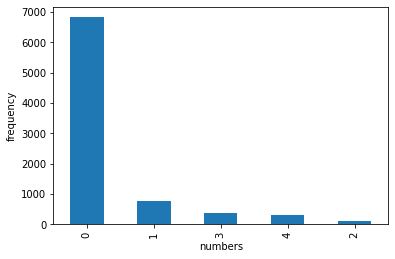

In [4]:
# Plot graph of Frequency of Class Labels
fig, ax = plt.subplots()
df['class_labels'].value_counts().plot(ax=ax, kind='bar', xlabel='numbers', ylabel='frequency')
plt.show()

<AxesSubplot:xlabel='class_labels'>

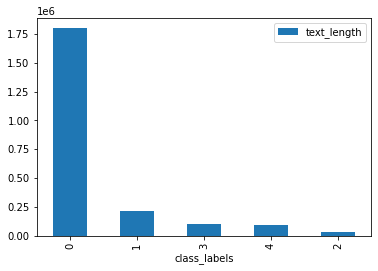

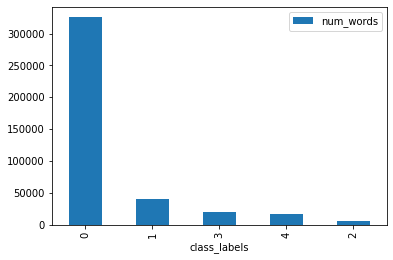

In [5]:
df['text_length'] = [len(txt) for txt in df['text']]

# Plot graph of Class Labels v/s text length
txt_lengths = df.groupby(["class_labels"]).text_length.sum().reset_index().sort_values('text_length', ascending=False)
txt_lengths.plot(x="class_labels", y="text_length", kind="bar")


# Plot graph of Class Labels v/s num, words
df['num_words'] = [len(txt.split()) for txt in df['text']]
num_words = df.groupby(["class_labels"]).num_words.sum().reset_index().sort_values('num_words', ascending=False)
num_words.plot(x="class_labels", y="num_words", kind="bar")


Total Number of Countries: 20


<AxesSubplot:xlabel='country code', ylabel='frequency'>

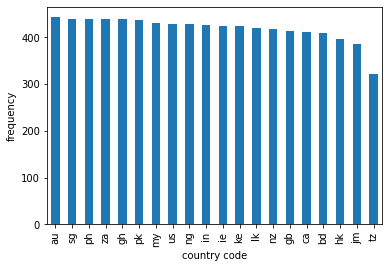

In [6]:
# Plot graph of Which Country the text originates most from
fig, ax = plt.subplots()
print("Total Number of Countries:", len(df['country_code'].unique()))
df['country_code'].value_counts().plot(ax=ax, kind='bar', xlabel='country code', ylabel='frequency')

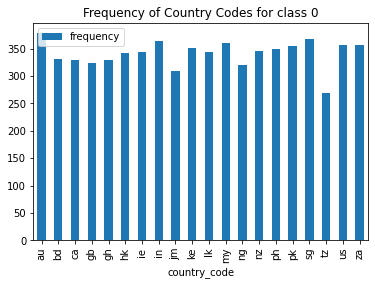

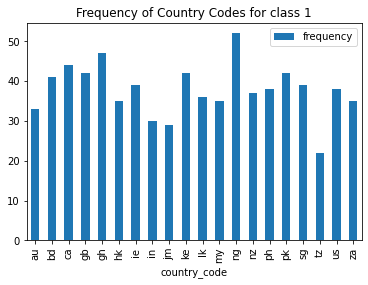

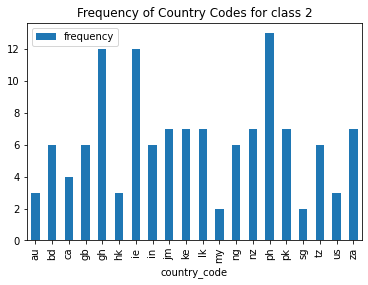

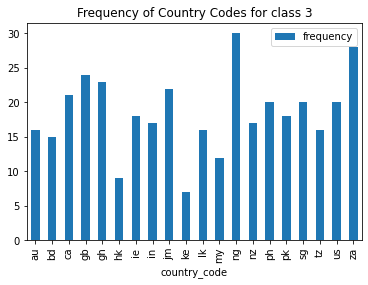

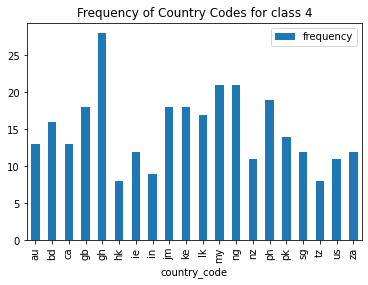

In [7]:
# Plot for each class, which country is most present
labels_by_country = df.groupby(["class_labels", "country_code"]).size().reset_index()
labels_by_country.rename(columns={0: 'frequency'}, inplace=True)

for cls in labels_by_country['class_labels'].unique():
  tbl = labels_by_country[labels_by_country['class_labels'] == cls].sort_values('country_code', ascending=True)
  tbl.plot(y="frequency", x='country_code', kind='bar', title=f"Frequency of Country Codes for class {cls}")

## Preprocess and build model

In [8]:
""" PREPROCESS """
# drop rows with empty text
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)
# drop rows with empty labels
df = df[df['class_labels'] != '']
df = df.reset_index(drop=True)

df = df[['text', 'class_labels']]
df.head()

,text,class_labels
0,"We 're living in times of absolute insanity , ...",0
1,"In Libya today , there are countless number of...",0
2,White House press secretary Sean Spicer said t...,0
3,Council customers only signs would be displaye...,0
4,""" Just like we received migrants fleeing El Sa...",0


In [9]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset

# Split the data into train and test
train, test = train_test_split(df, test_size=0.4, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Create a dataset from the pandas dataframe
validation, test = train_test_split(test, test_size=0.5, random_state=42)
validation = validation.reset_index(drop=True)

dataset = DatasetDict({"train": Dataset.from_dict({"text": train["text"], "label": train["class_labels"]}), "validation": Dataset.from_dict({"text": validation["text"], "label": validation["class_labels"]}), "test": Dataset.from_dict({"text": test["text"], "label": test["class_labels"]})})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5025
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1675
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1675
    })
})

In [10]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
small_validation_dataset = tokenized_dataset["validation"].shuffle(seed=42).select(range(1000))
small_test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

Map:   0%|          | 0/5025 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

Map:   0%|          | 0/1675 [00:00<?, ? examples/s]

## HyperParameter Tuning

In [11]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from datasets import load_metric
# from ray.tune.suggest.hyperopt import HyperOptSearch
# from ray.tune.schedulers import ASHAScheduler
 
def compute_metrics(eval_pred: EvalPrediction):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   preds, labels = eval_pred
   predictions = np.argmax(preds, axis=1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
   return {"accuracy": accuracy, "f1": f1}


model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=5)
model.to(device)

training_args = TrainingArguments(
  output_dir="finetuned_dontpatronizeme_model",
  evaluation_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  num_train_epochs=5,
  weight_decay=0.01,
  save_strategy="epoch",
)
 
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=small_train_dataset,
  eval_dataset=small_validation_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

# best_trial = trainer.hyperparameter_search(
#   direction="maximize",
#   backend="ray",
#   search_alg=HyperOptSearch(metric="objective", mode="max"),
#   scheduler=ASHAScheduler(metric="objective", mode="max")
# )

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.689556,0.803000,0.715262
2,No log,0.664528,0.793000,0.750380
3,No log,0.639548,0.792000,0.754518
4,No log,0.665591,0.791000,0.757013
5,No log,0.681407,0.791000,0.757936


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
<ipython-input-11-eede3cce55ee>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-63
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-63/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-63/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-63/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-63/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-126
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-126/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoin

TrainOutput(global_step=315, training_loss=0.5636332194010417, metrics={'train_runtime': 100.3806, 'train_samples_per_second': 49.81, 'train_steps_per_second': 3.138, 'total_flos': 172241670454080.0, 'train_loss': 0.5636332194010417, 'epoch': 5.0})

In [12]:
res = trainer.evaluate()
res

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'eval_loss': 0.6814066171646118,
 'eval_accuracy': 0.791,
 'eval_f1': 0.7579355639097743,
 'eval_runtime': 4.9122,
 'eval_samples_per_second': 203.574,
 'eval_steps_per_second': 12.825,
 'epoch': 5.0}

## Train with optimized parameters on train+validation dataset test on test dataset